# Calculate info between MA response and song timepoints at different lags

In [1]:
%matplotlib inline
from itertools import product as cproduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mutual_info_score
import sys

import warnings; warnings.filterwarnings("ignore")

from disp import set_plot


cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

PFX_NRL = f'data/simple/mlv/ma_built/nrl/ma_built'

## Define complete neural population

In [2]:
# neural params
TAU_R = np.array([.1, .5, 1, 2, 5, 10, 30, 60, 120, 180, 240, 480, 600])
TAU_A = np.array([.1, .5, 1, 2, 5, 10, 30, 60, np.inf])
X_S = np.array([0, .5, 1])

tau_r_tau_a_x_s = np.array(list(cproduct(TAU_R, TAU_A, X_S)))

tau_rs = tau_r_tau_a_x_s[:, 0]
tau_as = tau_r_tau_a_x_s[:, 1]
x_ss = tau_r_tau_a_x_s[:, 2]
x_ps = 1 - x_ss  # pulse selectivity

nr = len(tau_rs)
r_cols = [f'R_{cr}' for cr in range(nr)]

# Compute information

In [3]:
R_COLS = [f'R_{ir}' for ir in range(nr)]

In [4]:
# load all neural recordings
dfs_tr = [np.load(f'{PFX_NRL}_tr_{itr}.npy', allow_pickle=True)[0]['df'] for itr in ISTRAIN]

# extract songs
songs_full = []
for df_tr in dfs_tr:
    song = np.zeros(len(df_tr))
    song[df_tr['S'] == 1] = 1
    song[df_tr['P'] == 1] = 2
    
    songs_full.append(song)

# only keep neural activity after first song onset
it_song_starts = [np.nonzero(np.array(df_tr['Q']) == 0)[0][0] for df_tr in dfs_tr]
frs_tr = [np.array(df_tr[R_COLS])[it_song_start:, :] for df_tr, it_song_start in zip(dfs_tr, it_song_starts)]
songs_tr = [song[it_song_start:] for song, it_song_start in zip(songs_full, it_song_starts)]

In [11]:
# compute information between firing rates and song at different delayed timepoints
NBIN_R = 16
BIN_RS = np.linspace(0, 1, NBIN_R+1)  # firing rate bins
BIN_SONGS = np.array([-.5, .5, 1.5, 2.5])

ILAGS = np.array([
    1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000
])

def make_hist(frs, songs, ilag, inrn):
    # make firing rate/song joint histogram
    fr_cc = cc([frs_[ilag:, inrn] for frs_ in frs])
    song_cc = cc([song[:-ilag] if ilag > 0 else song for song in songs])
    
    fr_cc /= np.max(fr_cc)
    
    hist = np.histogram2d(fr_cc, song_cc, bins=[BIN_RS, BIN_SONGS])[0]
    return hist

mis = np.nan*np.zeros((nr, len(ILAGS)))

for cnrn in range(nr):
    sys.stdout.write('.')
    for cilag, ilag in enumerate(ILAGS):
                      
        hist = make_hist(frs_tr, songs_tr, ilag, cnrn)
        mi = mutual_info_score(None, None, contingency=hist)
        
        mis[cnrn, cilag] = mi

...............................................................................................................................................................................................................................................................................................................................................................

In [12]:
np.save('data/simple/song_info/mi_v_lag.npy', np.array([{
    'mis': mis, 'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss
}]))

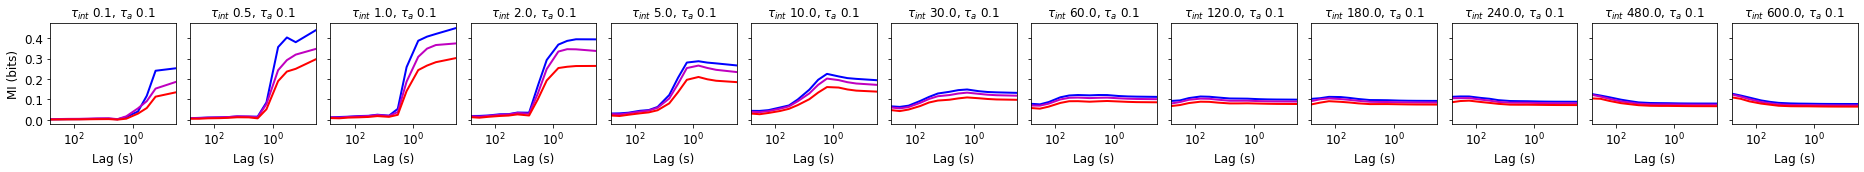

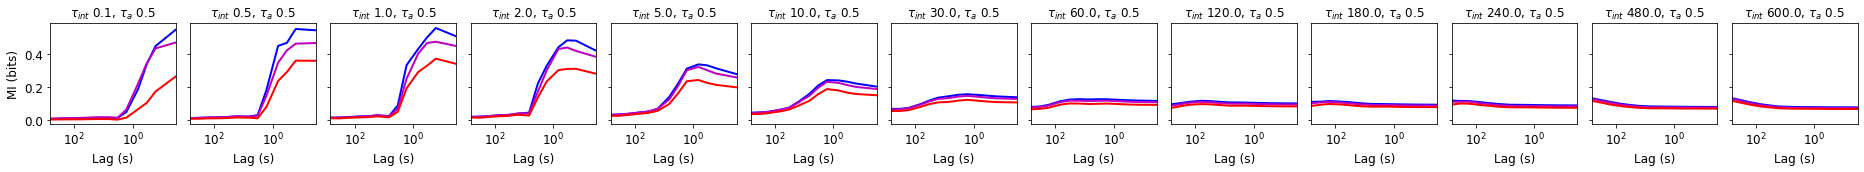

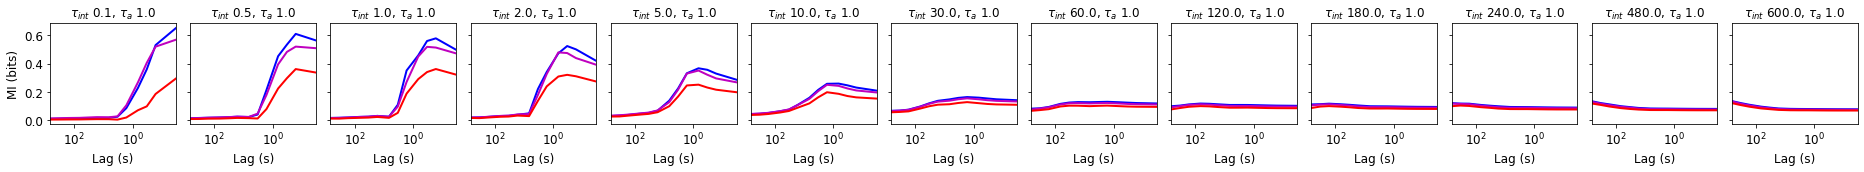

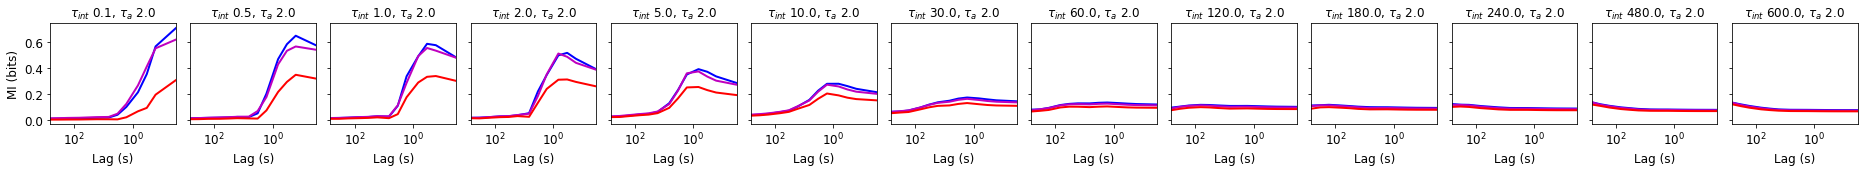

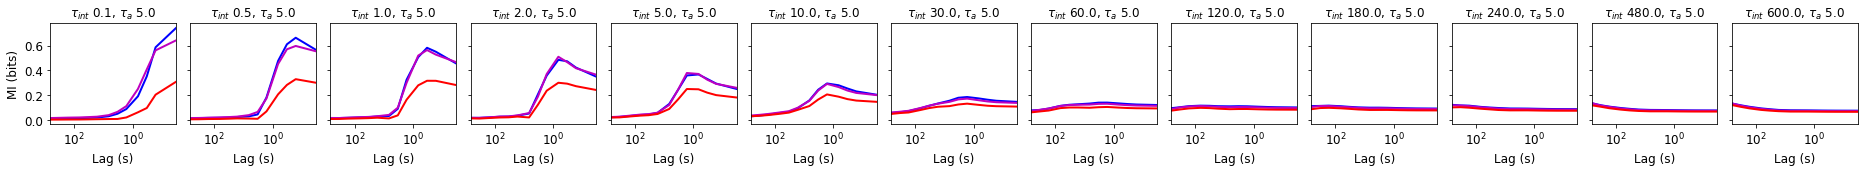

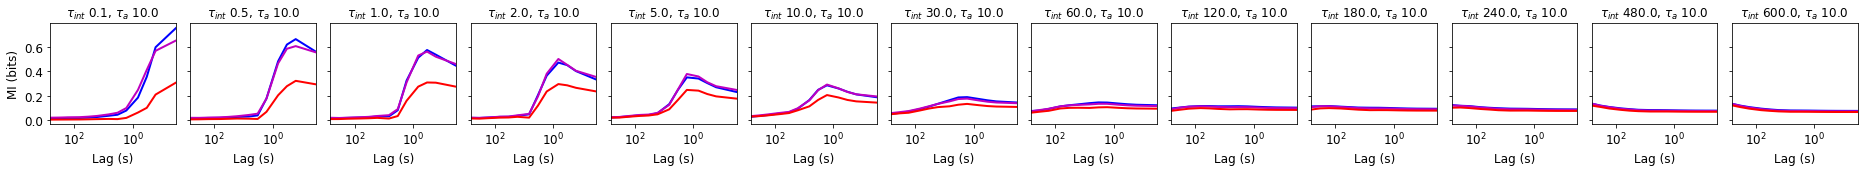

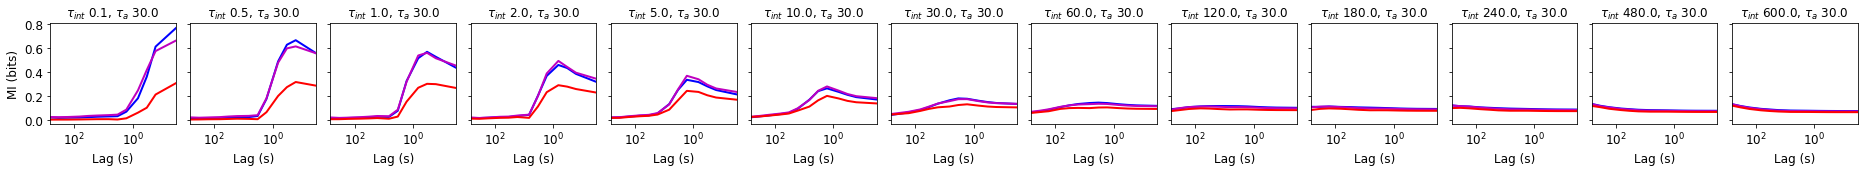

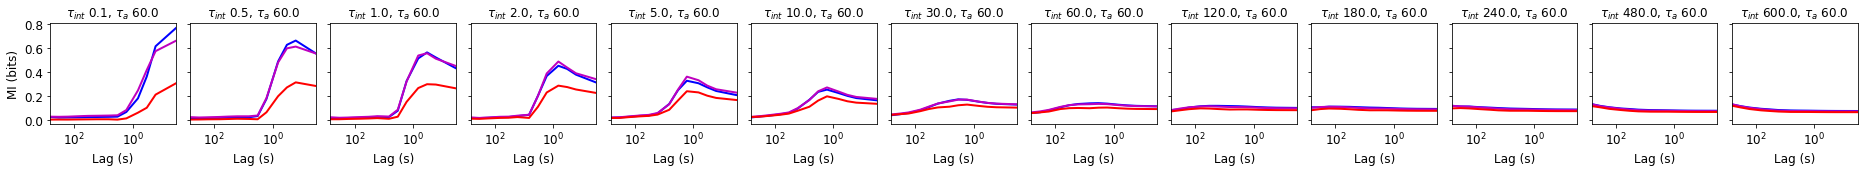

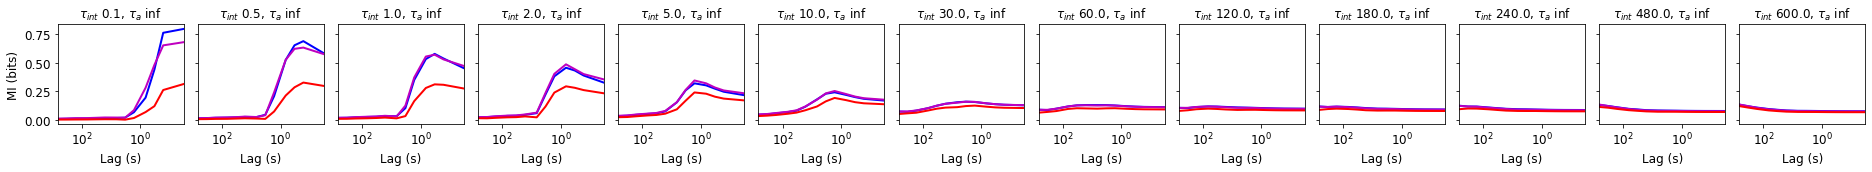

In [22]:
mis = np.load('data/simple/song_info/mi_v_lag.npy', allow_pickle=True)[0]['mis']

for tau_a in TAU_A:
    fig, axs = plt.subplots(1, len(TAU_R), figsize=(2*len(TAU_R), 2.5), tight_layout=True, sharey=True)
    
    for tau_r, ax in zip(TAU_R, axs):
        for x_s, color in zip([1, .5, 0], ['b', 'm', 'r']):
            # get idx of model neuron
            temp = np.isclose(tau_a, tau_as) & np.isclose(tau_r, tau_rs) & np.isclose(x_s, x_ss)
            assert np.sum(temp) == 1
            inrn = np.nonzero(temp)[0][0]
            
            # convert to bits
            ax.semilogx(ILAGS*DT, mis[inrn, :]*1.442695, c=color, lw=2)
            
            set_plot(ax, x_lim=(ILAGS[-1]*DT, DT), x_label='Lag (s)', title=r'$\tau_{int}$ ' + f'{tau_r:.1f}, ' + r'$\tau_a$ ' + f'{tau_a:.1f}')
        
    set_plot(axs[0], y_label='MI (bits)')
    
    fig.savefig(f'supp/s10_1_mi_song_timepoints_tau_a_{tau_a}.svg')